<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Exploratory-Data-Analysis-and-Metric" data-toc-modified-id="Exploratory-Data-Analysis-and-Metric-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Exploratory Data Analysis and Metric</a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Model</a></span></li><li><span><a href="#Submit" data-toc-modified-id="Submit-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Submit</a></span></li><li><span><a href="#Homework" data-toc-modified-id="Homework-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Homework</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Часть-1.-(4-балла)" data-toc-modified-id="Часть-1.-(4-балла)-4.0.1"><span class="toc-item-num">4.0.1&nbsp;&nbsp;</span>Часть 1. (4 балла)</a></span></li><li><span><a href="#Часть-2.-(3-баллов)" data-toc-modified-id="Часть-2.-(3-баллов)-4.0.2"><span class="toc-item-num">4.0.2&nbsp;&nbsp;</span>Часть 2. (3 баллов)</a></span></li></ul></li></ul></li></ul></div>

**[Kaggle InClass: Language Detection](https://www.kaggle.com/t/6b23f7b92b4b497e9aead739dd00ae1a)**

Датасет сильно не сбалансирован по классам, а требуется хорошее качество для всех языков, поэтому метрика в данном соревновании — взвешенная доля правильных ответов:

$$ 
\text{WeightedAccuracy}\left(y, \hat{y}, w\right) = \frac{\displaystyle{\sum_{i=1}^{n}} w_i \cdot \left(y_i == \hat{y}_i\right)}{\displaystyle\sum_{i=1}^{n} w_i } 
$$

Веса выбирались обратно пропорционально количеству примеров соответствующего языка:
$$
w\left(\text{"en"}\right) \sim \frac{1}{157655}
$$
$$ \dots $$
$$
w\left(\text{"kk"}\right) \sim \frac{1}{2046}
$$

Поэтому для валидации можно использовать [sklearn.metrics.balanced_accuracy_score](https://scikit-learn.org/stable/modules/model_evaluation.html#balanced-accuracy-score)

# Homework

### Часть 1. (4 балла)
- исследовать данные
    - почистить обучающую выборку
        - есть ли ошибки в разметке?
    - посмотреть, какие символы / токены встречаются во всех языках
    - выделить коллокации для известных вам языков (хотя бы русский и английский)
- попробовать добавить в модель признаки на основе word2vec или topic modeling
- построить confusion_matrix и посмотреть, какие языки путает модель
- вывести top_k токенов с максимальной важностью для каждого класса
 
### Часть 2. (3 баллов)
- выбить хороший score на private leaderboard'е

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.preprocessing  import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import balanced_accuracy_score
import re
import numpy as np
import nltk
import razdel
from tqdm import tqdm
from collections import Counter
import gensim
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import plot_confusion_matrix
from ast import literal_eval
from sklearn.preprocessing import StandardScaler
from IPython.display import Image

In [3]:
SEED = 42
np.random.seed(SEED)

In [4]:
DATA_PATH = '/Users/nikitaseleznev/Downloads'

# Exploratory Data Analysis and Metric

In [5]:
train_df = pd.read_csv(f'{DATA_PATH}/train.csv')

In [6]:
test_df = pd.read_csv(f'{DATA_PATH}/test.csv')

In [7]:
train_df.shape, test_df.shape

((3159633, 2), (2784634, 2))

In [8]:
# удаляю одинаковые строчки 
train_df = (train_df.drop(train_df[train_df.duplicated()].index)).reset_index(drop=True)

In [9]:
train_df.shape, test_df.shape

((2741628, 2), (2784634, 2))

In [10]:
# посмотрел есть ли ошибки в разметке, например, русского языка
rus_train = train_df[train_df['language'] == 'ru']

In [11]:
# есть ошибки
rus_train.head(5)

,sentence,language
10,После увольнения я решил собрать своих друзей ...,ru
13,"Ты знаешь , что это не гнев заставил моё сердц...",ru
26,гэта што калі мы не яны як але ён каб дзякуй б...,ru
40,"Ради всех имён , которые я никогда не узнаю , ...",ru
90,що це тому ми чи дуже які щоб дякую якщо було ...,ru


In [12]:
lang_count = train_df['language'].value_counts().to_frame().reset_index()

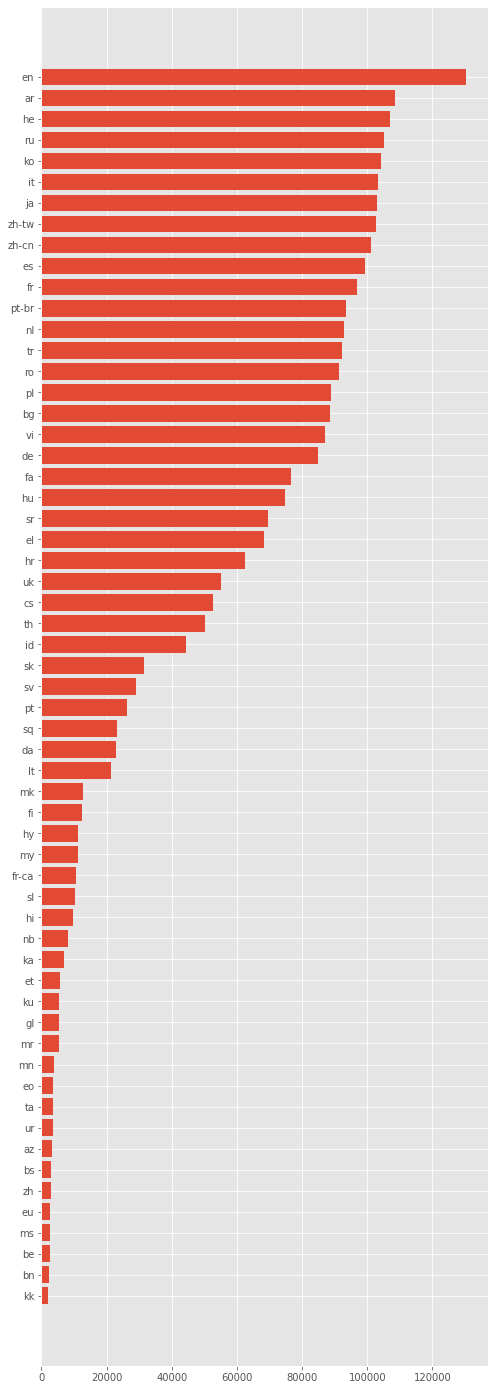

In [13]:
# теперь распределение выглядит так 
fig, ax = plt.subplots(figsize=(8,25))

ax.barh(lang_count['index'], lang_count['language'])

ax.invert_yaxis();

In [14]:
lang_count[lang_count['index'].apply(lambda x: x in {"en", "kk"})]

,index,language
0,en,130429
58,kk,2016


In [15]:
# выборка размера M по k неповторяющихся языков в каждом, чтобы для k различных  языков найти повторяющиеся символы
# M ограничивает количество, так как, например, по 4 различных языка из 59 это много - M = 455126
# N - количество предложений для языка(если N для какого то языка > size, беру все предложения)

def tokens_for_combinations_of_langs(N, k, M):
    if k == 'all':
        k = len(lang_count)
    
    lang_comb_k_all = np.array(list(combinations(lang_count['index'], k)))
    if M != 'all':
        lang_comb_k_M = lang_comb_k_all[np.random.choice(len(lang_comb_k_all), M)]
    else:
        lang_comb_k_M = lang_comb_k_all
        
    necessary_langs = dict()

    for k_langs in lang_comb_k_M:
        for lang in k_langs:
            text = ''
            
            if lang not in necessary_langs:
                df_lang = train_df[train_df['language'] == lang]['sentence']
                n = N
                if df_lang.shape[0] < N:
                    n = N
                    
                for sentence in df_lang.iloc[0:n]:
                    text += ' ' + sentence
                necessary_langs[lang] = set([token.text for token in razdel.tokenize(text.lower())])#set(nltk.tokenize.casual_tokenize(text.lower()))
                
    return necessary_langs, lang_comb_k_M

In [16]:
def print_similar_tokens(N=10000, k=4, M=25):
    necessary_langs, lang_comb_k_M = tokens_for_combinations_of_langs(N, k, M)
    union_M_set = set()
    for k_langs in lang_comb_k_M:
        print()
        print('языки: ', *k_langs, '\n')
        for i, lang in enumerate(k_langs):
            if i == 0:
                tmp_set = set(necessary_langs[lang])
            tmp_set &= set(necessary_langs[lang])
        print('повторяющиеся токены в них : ', *np.sort(list(tmp_set)))
        union_M_set |= tmp_set
    return np.sort(list(union_M_set))

In [17]:
# токены, которые довольно часто встречаются в пересечениях между k=4 различными языками, 
# видно, что в некоторых четверках встеряаются такие слова как: 'amazon', 'twitter', 'youtube', и т.д.
union = print_similar_tokens()


языки:  ko pt-br sr hr 

повторяющиеся токены в них :  ! # $ % & ( ) , - . .. ... / 0 1 10 100 1000 11 12 120 13 130 14 140 15 150 16 160 17 18 180 19 1906 1915 1945 1950 1960 1989 1990 1993 1996 1998 1999 2 2.0 20 200 2000 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2050 21 22 23 24 25 250 26 27 28 29 3 30 300 31 33 35 36 360 37 38 4 40 400 42 45 5 50 500 55 56 6 60 600 6000 62 7 70 75 8 80 800 85 9 90 91 93 95 97 99 : ; = ? a ag albert am amp and apos b bg bob c cm co com d da daf-2 dan dh dna do dr e el es fda fn g google hiv hotel i internet it j ja k kevin kg km l la led lego lhc m ma me mit more ms mt n nasa no o of org p pm project quot r radio s san star t ted the to trust tv u unicef video world x y z – — “ ” ♫

языки:  it nl fi kk 

повторяющиеся токены в них :  ! # % & ( ) , - . .. ... 1 10 100 1000 11 12 13 14 15 16 18 19 1960 1980 1997 1999 2 20 2000 2007 2008 2009 2010 2011 2015 23 24 25 250 26 27 3 30 300 3000 32 35 39 4 40 400 5 50 500 6 60 60

In [18]:
union

array(['!', '#', '$', '%', '&', '(', ')', '+', ',', '-', '.', '..', '...',
       '....', '/', '0', '000', '1', '1,3', '1,4', '1.2', '1.5', '10',
       '100', '100.000', '1000', '11', '110', '114', '12', '120', '13',
       '130', '14', '140', '15', '150', '150,000', '1500', '16', '160',
       '1600', '17', '170', '18', '180', '1800', '1858', '19', '1900',
       '1906', '1915', '1919', '1928', '1940', '1945', '1947', '1950',
       '1953', '1954', '1960', '1965', '1968', '1972', '1973', '1975',
       '1980', '1982', '1984', '1985', '1986', '1988', '1989', '1990',
       '1992', '1993', '1995', '1996', '1997', '1998', '1999', '2', '2,4',
       '2,5', '2.0', '20', '200', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012',
       '2013', '2014', '2015', '2020', '2030', '2050', '21', '22', '23',
       '24', '240', '25', '250', '26', '27', '270', '28', '29', '3', '30',
       '300', '3000', '31', '32', '33', '34', '35', '36', 

In [19]:
# токены по всех языках
cut_tokens = print_similar_tokens(N=10000, k='all', M='all')


языки:  en ar he ru ko it ja zh-tw zh-cn es fr pt-br nl tr ro pl bg vi de fa hu sr el hr uk cs th id sk sv pt sq da lt mk fi hy my fr-ca sl hi nb ka et ku gl mr mn eo ta ur az bs zh eu ms be bn kk 

повторяющиеся токены в них :  % & ( ) , - . ... : ; apos quot ted —


In [20]:
cut_tokens

array(['%', '&', '(', ')', ',', '-', '.', '...', ':', ';', 'apos', 'quot',
       'ted', '—'], dtype='<U4')

In [21]:
# оставил только цифры и символы для определения коллокаций
cut_tokens_for_colloc = np.array(list(set(cut_tokens) | set([x for x in union if not x.isalpha()])))

In [22]:
np.sort(cut_tokens_for_colloc)

array(['!', '#', '$', '%', '&', '(', ')', '+', ',', '-', '.', '..', '...',
       '....', '/', '0', '000', '1', '1,3', '1,4', '1.2', '1.5', '10',
       '100', '100.000', '1000', '11', '110', '114', '12', '120', '13',
       '130', '14', '140', '15', '150', '150,000', '1500', '16', '160',
       '1600', '17', '170', '18', '180', '1800', '1858', '19', '1900',
       '1906', '1915', '1919', '1928', '1940', '1945', '1947', '1950',
       '1953', '1954', '1960', '1965', '1968', '1972', '1973', '1975',
       '1980', '1982', '1984', '1985', '1986', '1988', '1989', '1990',
       '1992', '1993', '1995', '1996', '1997', '1998', '1999', '2', '2,4',
       '2,5', '2.0', '20', '200', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012',
       '2013', '2014', '2015', '2020', '2030', '2050', '21', '22', '23',
       '24', '240', '25', '250', '26', '27', '270', '28', '29', '3', '30',
       '300', '3000', '31', '32', '33', '34', '35', '36', 

In [23]:
#df_clear_sentence = train_df['sentence'].apply(lambda x: [token.text for token in razdel.tokenize(x.lower()) if token.text not in cut_tokens_for_colloc])

In [24]:
#train_clear_df = pd.concat((df_clear_sentence, train_df['language']), axis=1)

In [25]:
# т.к. сохранил, чтобы каждый раз не считать 
train_clear_df = pd.read_csv('/Users/nikitaseleznev/Desktop/train_clear_df.csv')

In [26]:
# снимаю str
train_clear_df['sentence'] = train_clear_df['sentence'].apply(lambda x: literal_eval(x))

In [27]:
train_clear_df[train_clear_df['language'] == 'ru']['sentence'].head(10)

10     [после, увольнения, я, решил, собрать, своих, ...
13     [ты, знаешь, что, это, не, гнев, заставил, моё...
26     [гэта, што, калі, мы, не, яны, як, але, ён, ка...
40     [ради, всех, имён, которые, я, никогда, не, уз...
90     [що, це, тому, ми, чи, дуже, які, щоб, дякую, ...
105    [как, очень, умные, мотивированные, осведомлён...
140    [я, думал, ну, наконец-то, большая, компания, ...
147    [я, думаю, что, это, последний, цикл, феномена...
164                       [вот, запланированный, проект]
185                 [таково, промышленное, производство]
Name: sentence, dtype: object

In [28]:
# коллокация для топ 4 языков(по количеству предложений)
cooccur_dict = dict()
for j, lang in tqdm(enumerate(lang_count['index'][0:4])):
    cooccurence = Counter()
    for col in train_clear_df[train_clear_df['language'] == lang]['sentence']:
        for i in range(len(col) - 1):
            cooccurence[(col[i], col[i + 1])] += 1
    cooccur_dict[lang] = cooccurence

4it [00:11,  2.80s/it]


In [29]:
# коллокации для en
cooccur_dict['en'].most_common(10)

[(('of', 'the'), 11736),
 (('it', 's'), 11700),
 (('in', 'the'), 10964),
 (('and', 'i'), 6293),
 (('this', 'is'), 5828),
 (('that', 's'), 5482),
 (('and', 'the'), 4973),
 (('i', 'm'), 4811),
 (('going', 'to'), 4668),
 (('to', 'the'), 4528)]

In [30]:
# коллокации для ar
cooccur_dict['ar'].most_common(10)

[(('،', 'و'), 2510),
 (('،', 'في'), 1689),
 (('الكثير', 'من'), 1594),
 (('في', 'الواقع'), 1468),
 (('يمكن', 'أن'), 1355),
 (('الآن', '،'), 1159),
 (('،', 'ولكن'), 1121),
 (('ذلك', '،'), 1113),
 (('،', 'أو'), 1075),
 (('في', 'هذه'), 1026)]

In [31]:
# коллокации для he
cooccur_dict['he'].most_common(10)

[(('את', 'זה'), 3501),
 (('זה', 'לא'), 1458),
 (('על', 'ידי'), 1227),
 (('זה', 'היה'), 1198),
 (('כל', 'כך'), 1194),
 (('מחיאות', 'כפיים'), 1174),
 (('את', 'כל'), 1172),
 (('אני', 'לא'), 1021),
 (('יש', 'לנו'), 984),
 (('על', 'זה'), 864)]

In [32]:
# коллокации для ru
cooccur_dict['ru'].most_common(15)

[(('потому', 'что'), 3168),
 (('то', 'что'), 2253),
 (('и', 'я'), 2021),
 (('что', 'мы'), 1939),
 (('том', 'что'), 1640),
 (('у', 'нас'), 1583),
 (('что', 'я'), 1582),
 (('что', 'это'), 1528),
 (('в', 'том'), 1456),
 (('и', 'это'), 1452),
 (('я', 'не'), 1434),
 (('так', 'что'), 1289),
 (('о', 'том'), 1265),
 (('мы', 'можем'), 1250),
 (('это', 'не'), 1217)]

# Model

In [33]:
train_x = train_clear_df['sentence'].str.join('')

In [34]:
train_x = pd.concat((train_x, train_df['language']), axis=1)

In [35]:
x = train_x.values[:, 0]
label_encoder = LabelEncoder().fit(train_x.values[:, 1])
y = label_encoder.transform(train_x.values[:, 1])

In [36]:
# веса для несбалансированного датасета
unique = np.unique(y)
values = compute_class_weight('balanced', unique, y)

dict_weights = dict()

for i, u in enumerate(unique):
    dict_weights[u] = values[i]

/Users/nikitaseleznev/PycharmProjects/TechnoSphereML/venv/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58], y=[17  6  6 ... 26 42 18] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [37]:
# очищу от всех цифр,которые оставлись, вряд ли они дают эффект
def preprocessor(string):
    return ''.join([char for char in string if char.isalpha()])

In [38]:
pipe = Pipeline([
    (
        'vectorizer', CountVectorizer(analyzer='char', ngram_range=(1, 2),
                                      preprocessor=preprocessor,
                                      min_df=20, max_df=0.8)
    ),
    ('model', SGDClassifier(random_state=SEED, loss='log', class_weight=dict_weights, n_jobs=-1))
])

In [39]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=SEED)

In [40]:
pipe.fit(x_train, y_train)

Pipeline(steps=[('vectorizer',
                 CountVectorizer(analyzer='char_wb', max_df=0.8, min_df=30,
                                 ngram_range=(1, 2),
                                 preprocessor=<function preprocessor at 0x7f90eb0b3820>)),
                ('model',
                 SGDClassifier(class_weight={0: 0.42787675352609233,
                                             1: 13.756148959869947,
                                             2: 18.28020109616077,
                                             3: 0.5251660905082409,
                                             4: 19.410305424578397,
                                             5: 15.38684476372208,
                                             6: 0.8820521465859436,
                                             7: 2.02264...
                                             15: 0.6072061361389384,
                                             16: 3.6908873063098233,
                                             17: 0.

In [41]:
balanced_accuracy_score(y_train, pipe.predict(x_train))

0.9119456924727259

In [42]:
balanced_accuracy_score(y_test, pipe.predict(x_test))

0.9092862641678624

In [43]:
pipe.fit(x, y)

Pipeline(steps=[('vectorizer',
                 CountVectorizer(analyzer='char_wb', max_df=0.8, min_df=30,
                                 ngram_range=(1, 2),
                                 preprocessor=<function preprocessor at 0x7f90eb0b3820>)),
                ('model',
                 SGDClassifier(class_weight={0: 0.42787675352609233,
                                             1: 13.756148959869947,
                                             2: 18.28020109616077,
                                             3: 0.5251660905082409,
                                             4: 19.410305424578397,
                                             5: 15.38684476372208,
                                             6: 0.8820521465859436,
                                             7: 2.02264...
                                             15: 0.6072061361389384,
                                             16: 3.6908873063098233,
                                             17: 0.

In [44]:
y_train_pred = pipe.predict(x)

In [45]:
balanced_accuracy_score(y, y_train_pred)

0.913009335751727

In [48]:
#возьму первые 20
labels = label_encoder.transform(list(lang_count['index'][0:20].values))

array([10,  0, 20, 44, 30, 26, 27, 58, 57, 12, 17, 42, 39, 52, 43, 40,  3,
       55,  8, 15])

<Figure size 432x288 with 0 Axes>

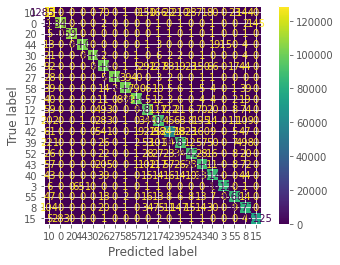

In [49]:
plt.figure()
plot_confusion_matrix(pipe, x, y, labels=labels)
plt.show()

# Submit

In [50]:
submit_predictions = pipe.predict(test_df.sentence.values)

In [51]:
test_df['language'] = label_encoder.classes_[submit_predictions]

test_df.head()

,index,sentence,language
0,0,תודה לכם .,he
1,1,"Precisamos de compaixão para começar , e auto-...",pt
2,2,這個增長相當大 ， 並且它將引發經濟的增長 。,zh-tw
3,3,시애틀에서 자란 제가 처음 가난을 보게 되던 때를 기억해요 .,ko
4,4,これをロボットに組み込みました,ja


In [52]:
(
    test_df[['index',  'language']]
    .to_csv(f'{DATA_PATH}/sample_submission.csv', index=False)
)

# Word2vec

In [53]:
sentence_datatrain = [list_ for list_ in train_clear_df['sentence']]
sentence_datatest = [list_ for list_ in train_clear_df['sentence']]
len(sentence_datatrain), len(sentence_datatest)

(2741628, 2741628)

In [54]:
sentence_dataset = sentence_datatrain + sentence_datatest
len(sentence_dataset)

5483256

In [55]:
word2vec = gensim.models.Word2Vec(
    size=30, sg=0, window=5, min_count=1, negative=10
)

In [56]:
word2vec.build_vocab(sentence_datatrain)

In [57]:
len(word2vec.wv.index2word)

3324961

In [58]:
word2vec.train(sentence_datatrain, total_examples=word2vec.corpus_count, epochs=10)

(399052138, 408529700)

In [59]:
word2vec.wv.most_similar('that')

[('which', 0.9766066074371338),
 ('actually', 0.9734954237937927),
 ('because', 0.9580172896385193),
 ('it', 0.9470193982124329),
 ('really', 0.9460031390190125),
 ('always', 0.9445149302482605),
 ('some', 0.9421529769897461),
 ('this', 0.941219687461853),
 ('whether', 0.9382261633872986),
 ('basically', 0.9362478852272034)]

In [60]:
index2word = np.array(word2vec.wv.index2word)

In [61]:
embeddings = word2vec.wv.vectors

In [62]:
embeddings.shape

(3324961, 30)

In [63]:
def embed_text(sentence, word2index, word_embeddings):
    return np.array([
        word_embeddings[word2index[word]] for word in sentence if word in word2index]).mean(0, keepdims=True)

In [64]:
word2index = {word: i for i, word in enumerate(index2word)}

In [65]:
feat_array = np.array([embed_text(sentence, word2index, embeddings)[0] if sentence else word2vec['that'] for sentence in train_clear_df['sentence']])

<ipython-input-65-9c01c32088ab>:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  feat_array = np.array([embed_text(sentence, word2index, embeddings)[0] if sentence else word2vec['that'] for sentence in train_clear_df['sentence']])


In [66]:
feat_array.shape

(2741628, 30)

In [67]:
new_features = pd.DataFrame(data=feat_array)

In [ ]:
# new_features.to_csv('/Users/nikitaseleznev/Desktop/new_feautures.csv')

In [68]:
#new_features = pd.read_csv('/Users/nikitaseleznev/Desktop/new_feautures.csv')

In [69]:
la_1 = SGDClassifier()

In [70]:
X_train, X_test, Y_train, Y_test = train_test_split(new_features.values, y, test_size=0.2)

In [71]:
la_1.fit(X_train, Y_train)

SGDClassifier()

In [76]:
balanced_accuracy_score(Y_train, la_1.predict(X_train))

0.7717467357898844

In [78]:
balanced_accuracy_score(Y_test, la_1.predict(X_test))

0.7724871455440493

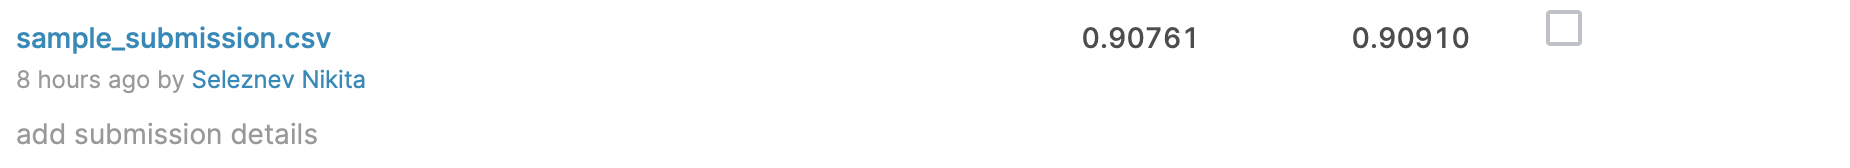

In [81]:
# score на CountVectorizer
Image('/Users/nikitaseleznev/Desktop/score.png', )